In [2]:
!pip install contractions
!pip install nltk

     |████████████████████████████████| 317kB 4.1MB/s 
     |████████████████████████████████| 245kB 44.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81705 sha256=2c1fa51d1fbef52d67ad10fa91b73e5eaaa46b32b8bee2a837e5d7510ea13678
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [31]:
import pandas as pd
import numpy as np
import re
import string
import contractions
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional,Attention,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from Attention import AttentionLayer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
dataset=pd.read_csv("./Reviews.csv",nrows=100000)
dataset=dataset.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time"],axis=1)
dataset=dataset.dropna(axis=0)

In [5]:
dataset.head(10)

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
5,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,Yay Barley,Right now I'm mostly just sprouting this so my...
9,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [ ]:
def preprocess_text(dataset):
    cleaned_text=[]
    for data in dataset:
        cleaned_data = data.lower()
        #remove htmltags
        html_tag = re.compile('<.*?>')
        cleaned_data= re.sub(html_tag,' ',cleaned_data)       
        cleaned_data=cleaned_data.strip()      
        #remove paranthsis data
        cleaned_data = re.sub(r'\([^)]*\)',' ', cleaned_data)
        cleaned_data = re.sub('"','',cleaned_data)
        #expand contractions
        cleaned_data=contractions.fix(cleaned_data)
        #remove punctuations
        cleaned_data = re.sub(r"'s\b"," ",cleaned_data)
        cleaned_data = cleaned_data.translate(str.maketrans(' ', ' ', string.punctuation))
        cleaned_text.append(cleaned_data)
    return cleaned_text

In [8]:
cleaned_reviews=[]
stop_words = set(stopwords.words('english')) 
cleaned_text_data=preprocess_text(dataset["Text"])
for text in cleaned_text_data:
    filtered_sentence = [w for w in text.split() if not w in stop_words] 
    long_words=[]
    for i in filtered_sentence:
        if len(i)>=3:   
            long_words.append(i)   
    cleaned_reviews.append(" ".join(long_words))
cleaned_reviews[:10]


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanutsthe peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal',
 'got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much redblack licoriceflavored pieces kids husband 

In [9]:
cleaned_Summary_data=preprocess_text(dataset["Summary"])
cleaned_Summary_data[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great  just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [ ]:
summary_tag=[]
for summary in cleaned_Summary_data:
    summary="<START> "+summary+" <END>"
    summary_tag.append(summary)
dataset["Text"]=cleaned_reviews
dataset["Summary"]=summary_tag

In [13]:
text_maximum_length=100
summary_maximum_length=10
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99998 entries, 0 to 99999
Data columns (total 2 columns):
Summary    99998 non-null object
Text       99998 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


In [ ]:
train_text,test_text,train_summary,test_summary=train_test_split(cleaned_reviews,summary_tag,test_size=0.3)

In [ ]:
review_tokenizer = Tokenizer()
review_tokenizer.fit_on_texts(list(train_text))

In [18]:
train_text[1]

'loved gummy bout green one tasty delicious would buy thanks'

In [19]:
test_text[1]

'tried hour energy long night year old stay next day hour sleep definitely woke kept awake duration day least body picked back crash afterwards stomach full like energy drinks agree others taste terrible taste great taste would recommend product anyone needs pickmeup keep day going smooth received free sample 5hour energy® fromsmiley360'

In [20]:
print(train_summary[1])

_START_ very good _END_


In [21]:
test_summary[1]

'_START_ wakes me up _END_'

In [ ]:
train_text=review_tokenizer.texts_to_sequences(train_text) 
train_text=pad_sequences(train_text,maxlen=text_maximum_length,padding='post') 
test_text=review_tokenizer.texts_to_sequences(test_text)
test_text=pad_sequences(test_text,maxlen=text_maximum_length,padding='post')

In [24]:
review_vocab_size=len(review_tokenizer.word_index) +1
review_vocab_size

73961

In [25]:
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(list(train_summary))
train_summary=summary_tokenizer.texts_to_sequences(train_summary) 
train_summary=pad_sequences(train_summary,maxlen=summary_maximum_length,padding='post')
test_summary=summary_tokenizer.texts_to_sequences(test_summary)
test_summary=pad_sequences(test_summary,maxlen=summary_maximum_length,padding='post')
summary_vocab_size=len(summary_tokenizer.word_index) +1
latent_dim=500
summary_vocab_size

16482

In [35]:
review_inputs=Input(shape=(text_maximum_length,)) 
input_embedding=Embedding(review_vocab_size,latent_dim,trainable=True)(review_inputs) 
gru1=GRU(latent_dim,return_sequences=True,return_state=True)
enc_out1,h1=gru1(input_embedding)
gru2=GRU(latent_dim,return_sequences=True,return_state=True)
enc_out2,h2=gru2(enc_out1)
gru3=GRU(latent_dim,return_sequences=True,return_state=True)
enc_out3,h3=gru33(enc_out2)

dec_input=Input(shape=(None,))
dec_embedding_lyr=Embedding(summary_vocab_size, latent_dim,trainable=True)
dec_embedding=dec_embedding_lyr(dec_input)
dec_gru1=GRU(latent_dim,return_sequences=True,return_state=True)
dec_out,_=dec_gru1(dec_embedding,initial_state=[h3]) 
attention_layer=AttentionLayer()
attn_out,_= attention_layer([enc_out3, dec_out])

decoder_concat_input=Concatenate()([dec_out,attn_out])
dense=TimeDistributed(Dense(summary_vocab_size, activation='softmax'))
dec_output=dense(decoder_concat_input) 
model=Model([review_inputs,dec_input],dec_output) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 100, 500)     36980500    input_11[0][0]                   
__________________________________________________________________________________________________
gru_5 (GRU)                     [(None, 100, 500), ( 1501500     embedding_10[0][0]               
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [49]:
history=model.fit([train_text,train_summary[:,:-1]], train_summary.reshape(train_summary.shape[0],train_summary.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([test_text,test_summary[:,:-1]], test_summary.reshape(test_summary.shape[0],test_summary.shape[1], 1)[:,1:]))

Train on 89998 samples, validate on 10000 samples
Epoch 1/50
89998/89998 [==============================] - 397s 4ms/sample - loss: 2.3912 - val_loss: 2.2932
Epoch 2/50
89998/89998 [==============================] - 398s 4ms/sample - loss: 2.2161 - val_loss: 2.2113
Epoch 3/50
89998/89998 [==============================] - 397s 4ms/sample - loss: 2.0691 - val_loss: 2.1588
Epoch 4/50
89998/89998 [==============================] - 395s 4ms/sample - loss: 1.9232 - val_loss: 2.1292
Epoch 5/50
89998/89998 [==============================] - 395s 4ms/sample - loss: 1.7754 - val_loss: 2.1141
Epoch 6/50
89998/89998 [==============================] - 397s 4ms/sample - loss: 1.6283 - val_loss: 2.1180
Epoch 00006: early stopping


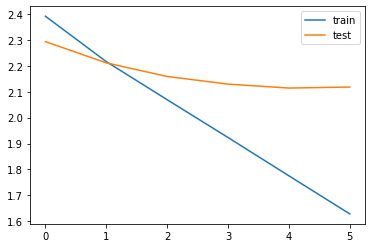

In [50]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
model.save("model_GRU.h5")

In [ ]:
encoder_model = Model(inputs=review_inputs,outputs=[enc_out3, h3])

dec_in_h = Input(shape=(latent_dim,))
dec_in_c = Input(shape=(latent_dim,))
dec_hidden_in = Input(shape=(text_maximum_length,latent_dim))

dec_emb2= dec_embedding_lyr(dec_input)

dec_out2,h= dec_lstm1(dec_emb2, initial_state=[dec_in_h])

attn_out_inf,_ = attention_layer([dec_hidden_in, dec_out2])

decoder_inf_concat = Concatenate()([dec_outp2, attn_out_inf])
decoder_outputs2 = dense(decoder_inf_concat)
decoder_model = Model([dec_input] + [dechidden_input,dec_in_h],[dec_out2] + [h])

In [ ]:
reverse_target_word=summary_tokenizer.index_word 
reverse_source_word=review_tokenizer.index_word 
target_word=summary_tokenizer.word_index
source_word=review_tokenizer.word_index

In [ ]:
ground_truth_review=[]
ground_truth_summery=[]
predicted_summary=[]
for n in range(len(test_text)):
    givenReview=''
    for review_token in test_text[n]:
        if(review_token!=target_word['start'] and review_token!=target_word['end']):
            givenReview=givenReview+reverse_source_word[review_token]+' '
    ground_truth_review.append(givenReview)
    givenSummary=''
    for summary_token in test_summary[n]:
        if(summary_token!=target_word['start'] and summary_token!=target_word['end']):
            givenSummary=givenSummary+reverse_target_word[summary_token]+' '
    ground_truth_summery.append(givenSummary)        
    e_out, e_h= encoder_model.predict(test_text[n].reshape(1,100))
    target_seq = np.zeros((1,1))
    target_seq[0][0] = target_word_index['start']
    decoded_sentence = ''
    while True:
        output_tokens, h = decoder_model.predict([target_seq] + [e_out, e_h])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (summary_maximum_length-1)):
            break
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h = h
    predicted_summary.append(decoded_sentence)

In [59]:
for i in range(15):
    print("\n")
    print("Review: {}".format(ground_truth_review[i]))
    print("Actual Summary: {}".format(ground_truth_summery[i]))
    print("Predicted Summary:{}".format(predicted_summary[i]))
    



Review: rarely eat anything whole wheat pasta every eat treat almost pastas ate italy make sure cook 
Actual Summary: reminds me of italy 
Predicted Summary: great gluten free pasta


Review: tried hour energy long night year old stay next day hour sleep definitely woke kept awake duration day least body picked back crash afterwards stomach full energy drinks agree others taste terrible taste great taste would recommend product anyone needs pickmeup keep day going smooth received free sample 5hour energy® 
Actual Summary: wakes me up 
Predicted Summary: energy boost


Review: tried several one right amount sea salt added distract chocolate adds flavor favorite many strong favorites dark chocolate bars one seems one get combination right 
Actual Summary: best almonds and sea salt chocolate bar 
Predicted Summary: great snack


Review: greenies muched loved tatsy treat two small dogs chews last long time 
Actual Summary: excellent teeth cleaner 
Predicted Summary: greenies are the best

In [60]:
from nltk.translate.bleu_score import sentence_bleu
from statistics import mean 
score=[]
for i in range(100):
    reference=list(ground_truth_summery[i].split())
    candidate=list(predicted_summary[i].split())
    score.append(sentence_bleu(reference,candidate,weights=(1,0,0,0)))

mean(score)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.012827937696632154

In [ ]:
from pythonrouge.pythonrouge import Pythonrouge
for i in range(100):
    reference=ground_truth_summery[i]
    candidate=predicted_summary[i]
    rouge = Pythonrouge(summary_file_exist=False,
                    summary=candidate, reference=reference,
                    n_gram=1, ROUGE_SU4=True, ROUGE_L=False,
                    recall_only=True, stemming=True, stopwords=True,
                    word_level=True, length_limit=True, length=50,
                    use_cf=False, cf=95, scoring_formula='average',
                    resampling=True, samples=1000, favor=True, p=0.5)
    score = rouge.calc_score()
    print(score)

{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'ROUGE-SU4': 0.0}
{'ROUGE-1': 0.0, 'RO